_DongHee (Python 3.7.16)에 연결 중..._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the Elo rating update function
def update_elo(rating1, rating2, result1):
    K = 34
    expected1 = 1.0 / (1 + 10**((rating2 - rating1) / 400))
    expected2 = 1.0 - expected1
    new_rating1 = rating1 + K * (result1 - expected1)
    new_rating2 = rating2 + K * (1 - result1 - expected2)
    return new_rating1, new_rating2

data = pd.read_excel('Soccer Data.xlsx')
df = pd.DataFrame(data)

In [2]:
# Initialize Elo ratings for teams
ratings = {team: 1500 for team in set(df['Team Name']).union(set(df['opponent_Team']))}
rating_history = {team: [1500] for team in ratings}

# Update ratings based on match results and store history
for index, row in df.iterrows():
    team1, team2, result = row['Team Name'], row['opponent_Team'], row['Result']
    if result == 'Win':
        new_ratings = update_elo(ratings[team1], ratings[team2], 1)
    elif result == 'Draw':
        new_ratings = update_elo(ratings[team1], ratings[team2], 0.5)
    else:  # Lose
        new_ratings = update_elo(ratings[team1], ratings[team2], 0)
    ratings[team1], ratings[team2] = new_ratings
    rating_history[team1].append(ratings[team1]) 

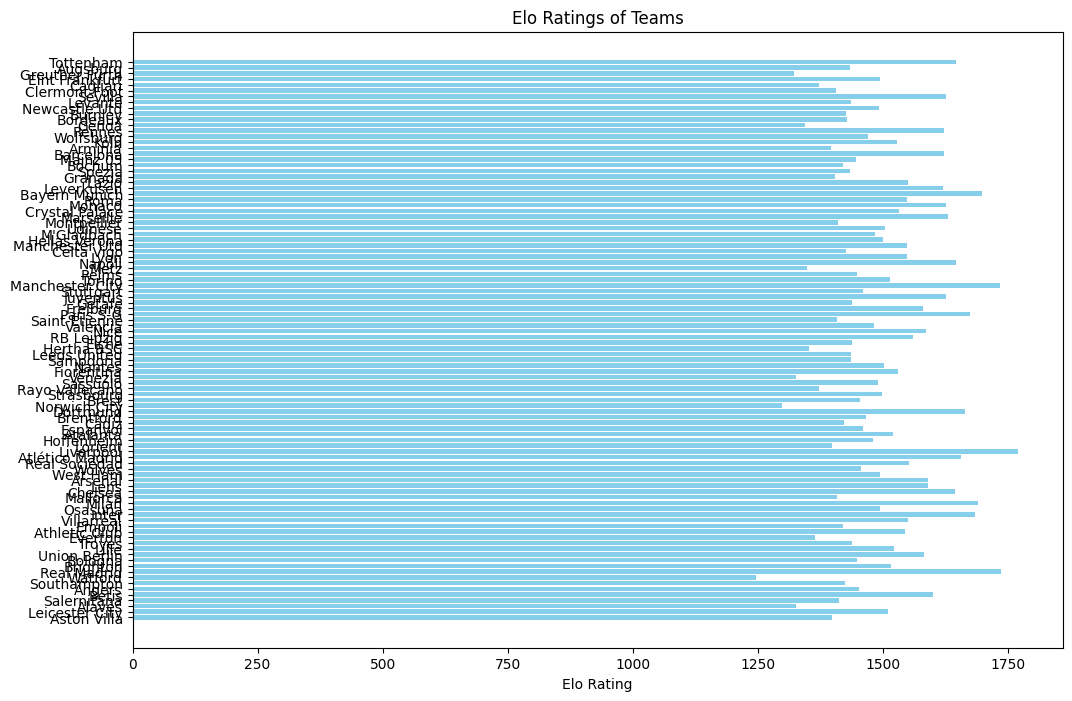

In [3]:
# Visualization
teams = list(ratings.keys())
elo_scores = list(ratings.values())

plt.figure(figsize=(12, 8))
plt.barh(teams, elo_scores, color='skyblue')
plt.xlabel('Elo Rating')
plt.title('Elo Ratings of Teams')
plt.gca().invert_yaxis()
plt.show()

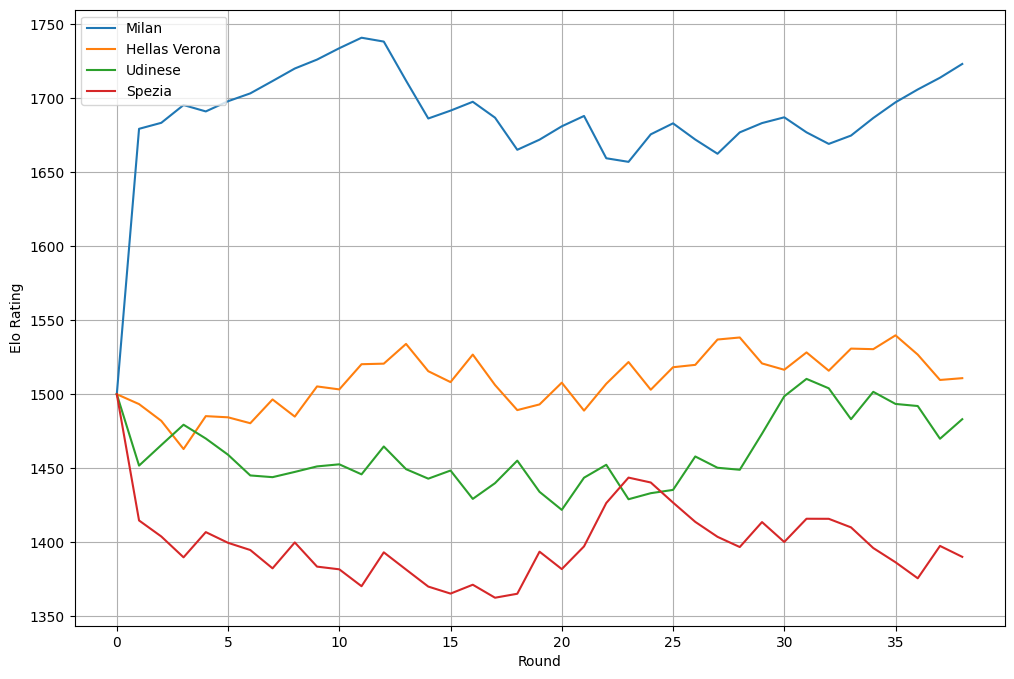

In [4]:
# Visualization for specific teams
specific_teams = ['Milan', 'Hellas Verona', 'Udinese' , 'Spezia']  # Add or remove teams as needed
plt.figure(figsize=(12, 8))
for team in specific_teams:
    plt.plot(rating_history[team], label=team)

plt.xlabel('Round')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Rolling Regression to identify trends
window_size = 5
trends = {}

for team, elos in rating_history.items():
    if len(elos) < window_size:
        trends[team] = 'Insufficient data'
        continue

    slopes = []
    for i in range(len(elos) - window_size + 1):
        y = elos[i:i+window_size]
        X = np.array(range(window_size)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        slopes.append(reg.coef_[0])

    # Determine trend based on average slope
    avg_slope = np.mean(slopes)
    if avg_slope > 0:
        trends[team] = 'Upswing'
    elif avg_slope < 0:
        trends[team] = 'Downswing'
    else:
        trends[team] = 'Stable'

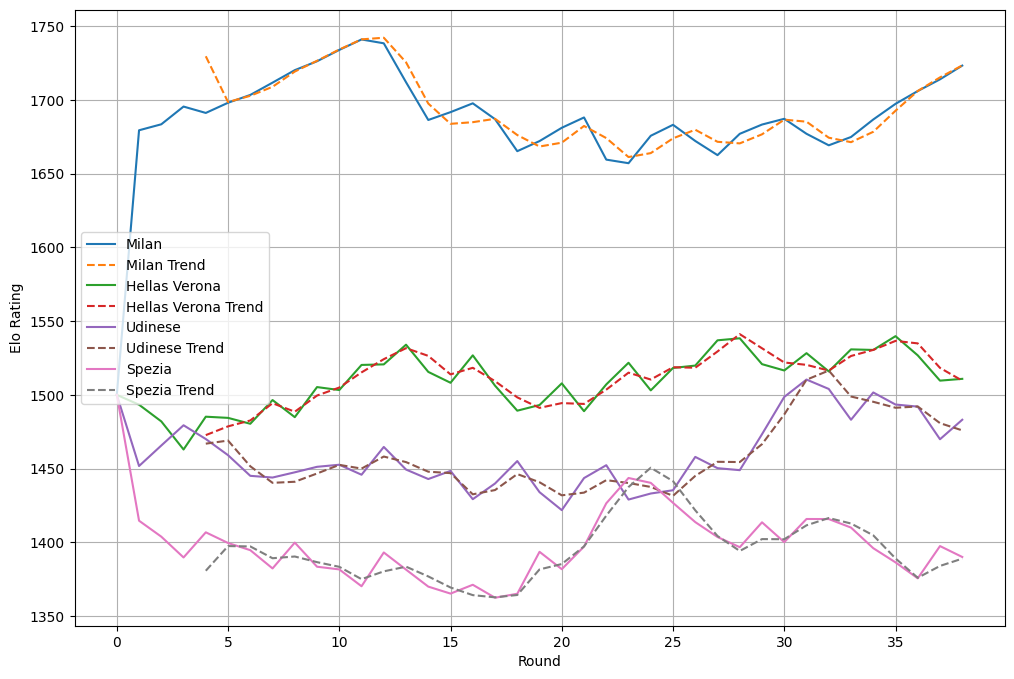

In [6]:
# Visualization for specific teams
specific_teams = ['Milan', 'Hellas Verona', 'Udinese' , 'Spezia']  # Add or remove teams as needed
plt.figure(figsize=(12, 8))
for team in specific_teams:
    plt.plot(rating_history[team], label=team)

    # Rolling Regression for trend visualization
    elos = rating_history[team]
    rolling_regression = []
    for i in range(len(elos) - window_size + 1):
        y = elos[i:i+window_size]
        X = np.array(range(window_size)).reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        rolling_regression.append(reg.predict([[window_size-1]])[0])
    plt.plot(range(window_size-1, len(elos)), rolling_regression, linestyle='--', label=f'{team} Trend')

plt.xlabel('Round')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Function to determine trend based on value change
def determine_trend_by_value_change(rolling_averages):
    trends = []
    for i in range(1, len(rolling_averages)):
        if rolling_averages[i] > rolling_averages[i-1]:
            trends.append('Upswing')
        elif rolling_averages[i] < rolling_averages[i-1]:
            trends.append('Downswing')
        else:
            trends.append('Stable')
    return trends

# Check trends for all teams
all_teams = list(rating_history.keys())
trend_table = pd.DataFrame(index=all_teams)

window_size = 5  # You can adjust this as needed

for team in all_teams:
    elos = rating_history[team]
    if len(elos) < window_size:
        trend_table.loc[team, 'Trend'] = 'Insufficient data'
        continue

    # Calculate rolling averages
    rolling_averages = [np.mean(elos[max(0, i-window_size+1):i+1]) for i in range(len(elos))]

    # Determine trend based on value change
    trends = determine_trend_by_value_change(rolling_averages)
    
    # Store the most recent trend in the table
    trend_table.loc[team, 'Trend'] = trends[-1]

print(trend_table)

                    Trend
Tottenham         Upswing
Augsburg        Downswing
Greuther Fürth  Downswing
Eint Frankfurt  Downswing
Cagliari        Downswing
...                   ...
Betis             Upswing
Salernitana       Upswing
Alavés            Upswing
Leicester City  Downswing
Aston Villa       Upswing

[98 rows x 1 columns]


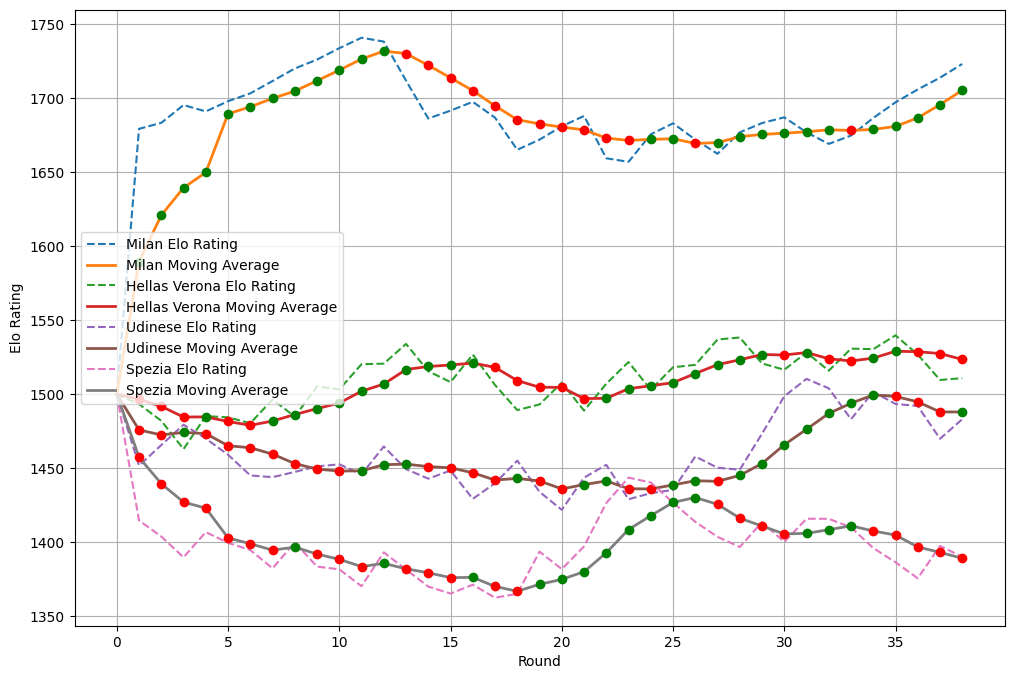

In [8]:
def determine_trend_by_value_change(rolling_averages):
    trends = ['Stable']  # Start with 'Stable' for the first value
    for i in range(1, len(rolling_averages)):
        if rolling_averages[i] > rolling_averages[i-1]:
            trends.append('Upswing')
        elif rolling_averages[i] < rolling_averages[i-1]:
            trends.append('Downswing')
        else:
            trends.append('Stable')
    return trends

window_size = 5
specific_teams = ['Milan', 'Hellas Verona', 'Udinese' , 'Spezia']  # Add or remove teams as needed

plt.figure(figsize=(12, 8))

for team in specific_teams:
    elos = rating_history[team]
    rolling_averages = [np.mean(elos[max(0, i-window_size+1):i+1]) for i in range(len(elos))]
    trends = determine_trend_by_value_change(rolling_averages)
    
    # Plot Elo ratings and moving average
    plt.plot(elos, label=f'{team} Elo Rating', linestyle='--')
    plt.plot(rolling_averages, label=f'{team} Moving Average', linewidth=2)
    
    # Highlight upward and downward trends
    for i, trend in enumerate(trends):
        if trend == 'Upswing':
            plt.plot(i, rolling_averages[i], 'go')  # Green dot for upward trend
        elif trend == 'Downswing':
            plt.plot(i, rolling_averages[i], 'ro')  # Red dot for downward trend

plt.xlabel('Round')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Calculate moving average for each team's Elo rating
window_size = 5

def moving_average(values):
    return [np.mean(values[max(0, i-window_size+1):i+1]) for i in range(len(values))]

moving_averages = {team: moving_average(elos) for team, elos in rating_history.items()}

# Determine trend based on change in moving average
def determine_trend(ma_values):
    trends = ['Stable']  # Initialize with 'Stable' for the first value
    for i in range(1, len(ma_values)):
        if ma_values[i] > ma_values[i-1]:
            trends.append('Upswing')
        elif ma_values[i] < ma_values[i-1]:
            trends.append('Dowswing')
        else:
            trends.append('Stable')
    return trends

trend_data = {team: determine_trend(ma) for team, ma in moving_averages.items()}

# Calculate the maximum number of games played by any team
max_length = max(len(elos) for elos in rating_history.values())

# Pad the trend lists to make them all the same length
for team, trends in trend_data.items():
    while len(trends) < max_length:
        trends.append('N/A')

# Convert trend data to DataFrame
Trend = pd.DataFrame(trend_data)

print(Trend)

   Tottenham  Augsburg Greuther Fürth Eint Frankfurt  Cagliari Clermont Foot  \
0     Stable    Stable         Stable         Stable    Stable        Stable   
1    Upswing  Dowswing       Dowswing       Dowswing  Dowswing       Upswing   
2    Upswing  Dowswing       Dowswing       Dowswing  Dowswing       Upswing   
3    Upswing  Dowswing       Dowswing       Dowswing  Dowswing       Upswing   
4    Upswing  Dowswing       Dowswing       Dowswing  Dowswing       Upswing   
5    Upswing   Upswing       Dowswing       Dowswing  Dowswing       Upswing   
6   Dowswing  Dowswing       Dowswing       Dowswing  Dowswing      Dowswing   
7   Dowswing  Dowswing       Dowswing        Upswing  Dowswing      Dowswing   
8   Dowswing  Dowswing       Dowswing        Upswing  Dowswing      Dowswing   
9   Dowswing  Dowswing       Dowswing       Dowswing  Dowswing      Dowswing   
10  Dowswing  Dowswing       Dowswing        Upswing  Dowswing      Dowswing   
11  Dowswing  Dowswing       Dowswing   